In [1]:
import pandas as pd
import os
os.chdir("..")
from bertopic import BERTopic
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from utils.entity_extractor import EntityExtractor
import numpy as np

### Examine results from topic modelling 

In [2]:
datasets = {
    "annomatic": pd.read_parquet("data/enriched/annomatic_full.parquet"),
    "babe": pd.read_parquet("data/enriched/babe_full.parquet"),
    "basil": pd.read_parquet("data/enriched/basil_full.parquet")
}

topic_models = {
    "annomatic": BERTopic.load("data/enriched/models/annomatic_model", embedding_model="all-MiniLM-L6-v2"),
    "babe": BERTopic.load("data/enriched/models/babe_model", embedding_model="all-MiniLM-L6-v2"),
    "basil": BERTopic.load("data/enriched/models/basil_model", embedding_model="all-MiniLM-L6-v2")}

In [11]:
for name, df in datasets.items():
    print(df["topic"].value_counts(dropna=False))

topic
None                                                            13003
0_climate_water_climate change_energy                            1202
1_god_church_jesus_christian                                     1042
2_game_season_team_football                                       911
3_woman_mother_daughter_said                                      836
                                                                ...  
138_moon_venus_sign_scorpio                                        29
142_eu_eurosceptic_euro_european                                   28
137_loan_student loan_student_borrowers                            27
141_strike_sag_sag aftra_aftra                                     26
140_univision_reliable democrat_commercials_democrat talking       25
Name: count, Length: 146, dtype: int64
topic
0_police_black_floyd_george                  483
None                                         479
14_trump_media_donald trump_donald           204
1_transgender_women_gay_sex     

In [17]:
for name, model in topic_models.items():
    fig = model.visualize_topics()  # Generate the visualization
    fig.update_layout(title=f"Topic Visualization for {name.capitalize()}")
    fig.show()


Babe has already annotated topics. We can compare them against those to see how coherent it is.
Although the annotated topic is in the article level, and bertopic is on the sentence. So actually it can give different results but it´s accurate for the sentence.

In [27]:
babe_raw = pd.read_csv("data/raw/babe.csv", sep=";")

merged_babe = pd.merge(babe_raw, datasets["babe"], on='text', how='inner')
merged_babe = merged_babe[['text', 'topic_x', 'topic_y']]

pd.set_option('display.max_colwidth', None) 
merged_babe.head(15)

,text,topic_x,topic_y
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",environment,18_green_new deal_green new_ocasio
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",gun control,16_trump_protesters_donald_donald trump
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",white-nationalism,0_police_black_floyd_george
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",white-nationalism,20_racist_trump_racism_president
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",marriage-equality,0_police_black_floyd_george
5,[Democrats employ] their full arsenal to delegitimize the Trump presidency for the apparent crime of winning the 2016 election.,vaccine,None
6,[Newsoms's] obsession with masks has created an almost hostile environment in our neighborhoods and streets.,vaccine,None
7,[Newsoms's] onslaught of propaganda ignores conflicting science on mask-wearing (some studies suggest it may even increase infection) and vilifying those who ever leave their house with a wish to breath unimpeded oxygen as they walk down the sidewalk alone.,vaccine,None
8,"[The police] now prefer to think of themselves more like glorified social workers, there to heal the wounds of a broken society by showing off their skateboarding skills at Extinction Rebellion protests and putting on makeup and rainbow lanyards to prance embarrassingly at Gay Pride festivals.",marriage-equality,0_police_black_floyd_george
9,‘A new low’: Washington Post media critic blows up Tucker Carlson’s absurd lies about white nationalism,white-nationalism,20_racist_trump_racism_president


### Examine results from Named Entity Recognition

In [3]:
entitiy_extractor = EntityExtractor()
for name, df in datasets.items():
    df['entities'] = df['entities'].apply(lambda x: entitiy_extractor.process_entities(x))

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

2025-01-16 08:55:55,328 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Error processing entity 'The Origin of Species': sequence item 1: expected str instance, bool found


Wordcloud for annomatic


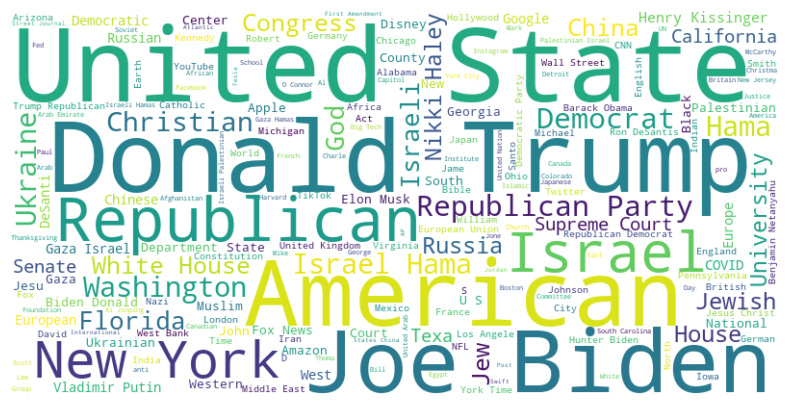

Wordcloud for babe


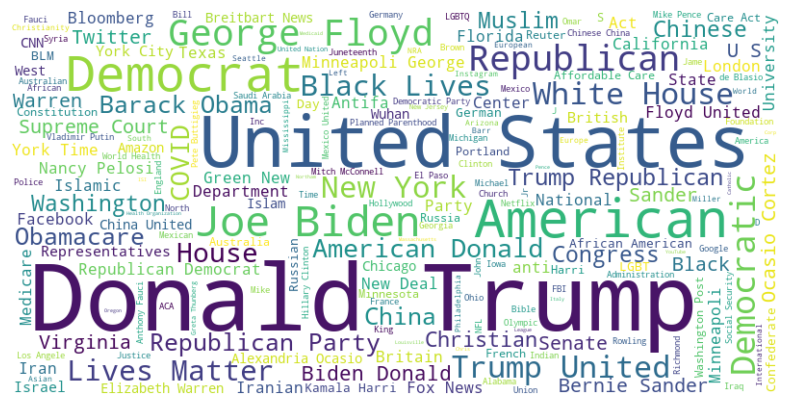

Wordcloud for basil


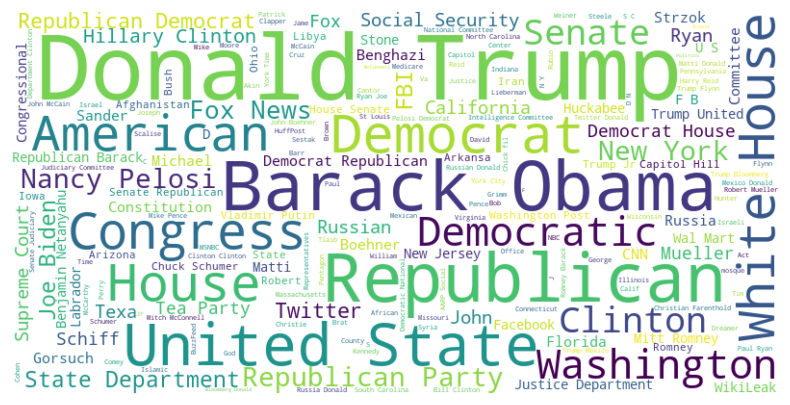

In [8]:
for name, df in datasets.items():
    all_entities = [str(entity) for entity in df["entities"].explode() if not pd.isna(entity)]
    text = ' '.join(all_entities)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    print(f"Wordcloud for {name}")
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


Cluster NER based on co-occurrence. VS_Entity = jaccard similarity. 

Won't do vs for entities, doesn't make a lot of sense and its already kind of covered with topics. Will use them for checking the models though.

In [4]:
# try different configurations
configurations = [
    {"min_cluster_size": 20, "min_samples": 5, "n_components": 50},
    {"min_cluster_size": 30, "min_samples": 10, "n_components": 100},
    {"min_cluster_size": 50, "min_samples": 15, "n_components": 50},   
]

results = {}

for name, df in datasets.items():
    results[name] = {}
    for i, config in enumerate(configurations):
        clustered_df = entitiy_extractor.cluster_entities(
            df.copy(), 
            min_cluster_size=config["min_cluster_size"],
            min_samples=config["min_samples"],
            n_components=config["n_components"]
        )
        
        results[name][f"config_{i+1}"] = {
            "config": config,
            "clustered_df": clustered_df
        }

In [5]:
for name, configs in results.items():
    print(f"Dataset: {name}")
    for config_name, data in configs.items():
        clustered_df = data["clustered_df"]
        num_clusters = clustered_df['entity_cluster'].nunique(dropna=True)
        print(f"  {config_name}: {data['config']}, Clusters: {num_clusters}")

Dataset: annomatic
  config_1: {'min_cluster_size': 20, 'min_samples': 5, 'n_components': 50}, Clusters: 168
  config_2: {'min_cluster_size': 30, 'min_samples': 10, 'n_components': 100}, Clusters: 109
  config_3: {'min_cluster_size': 50, 'min_samples': 15, 'n_components': 50}, Clusters: 59
Dataset: babe
  config_1: {'min_cluster_size': 20, 'min_samples': 5, 'n_components': 50}, Clusters: 20
  config_2: {'min_cluster_size': 30, 'min_samples': 10, 'n_components': 100}, Clusters: 10
  config_3: {'min_cluster_size': 50, 'min_samples': 15, 'n_components': 50}, Clusters: 9
Dataset: basil
  config_1: {'min_cluster_size': 20, 'min_samples': 5, 'n_components': 50}, Clusters: 50
  config_2: {'min_cluster_size': 30, 'min_samples': 10, 'n_components': 100}, Clusters: 27
  config_3: {'min_cluster_size': 50, 'min_samples': 15, 'n_components': 50}, Clusters: 16


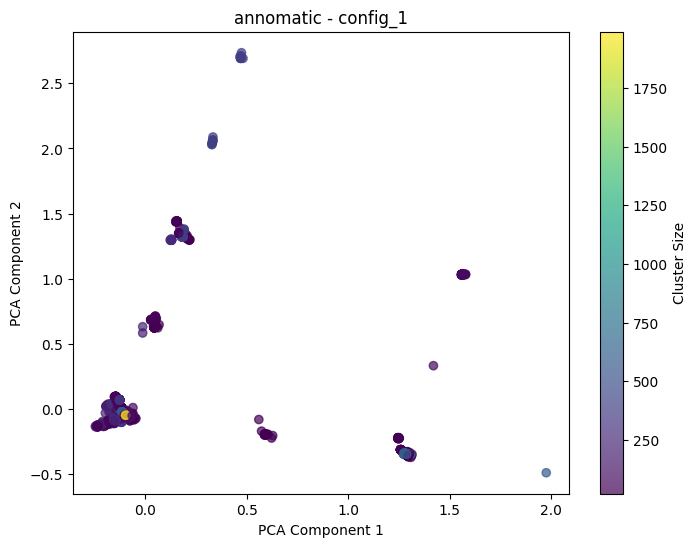

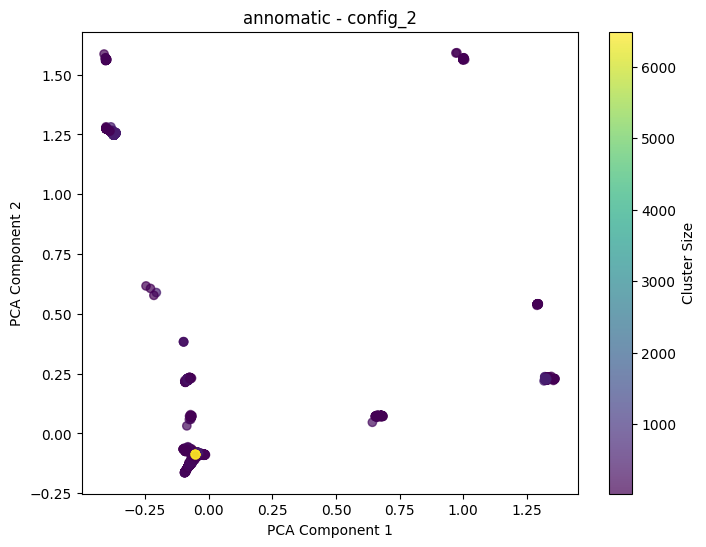

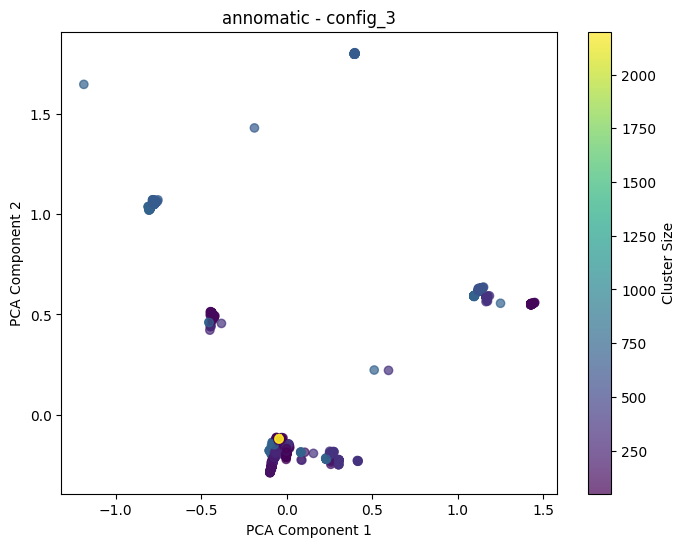

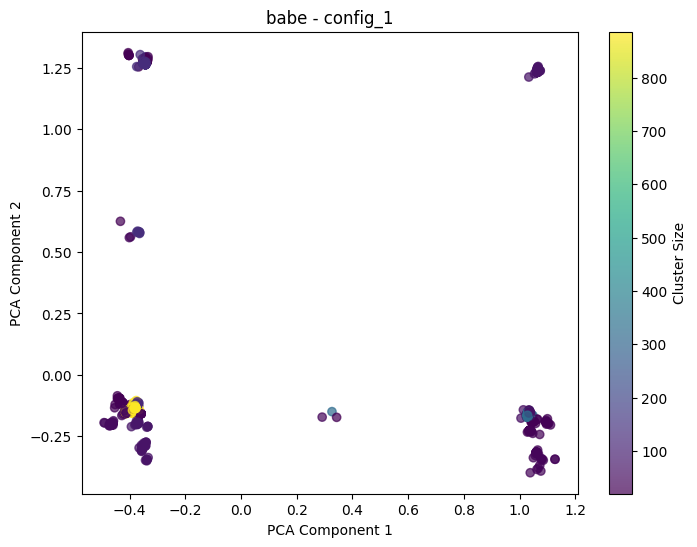

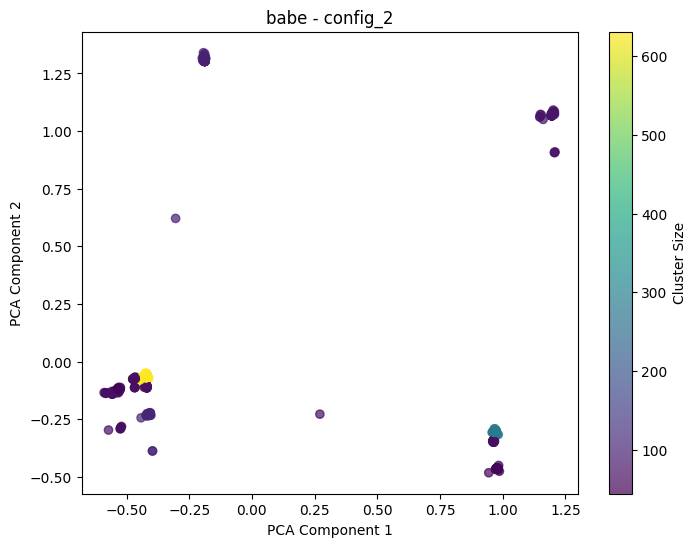

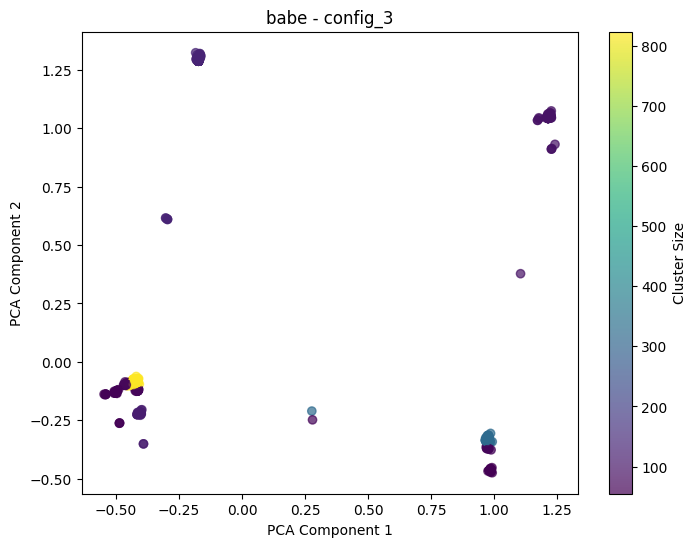

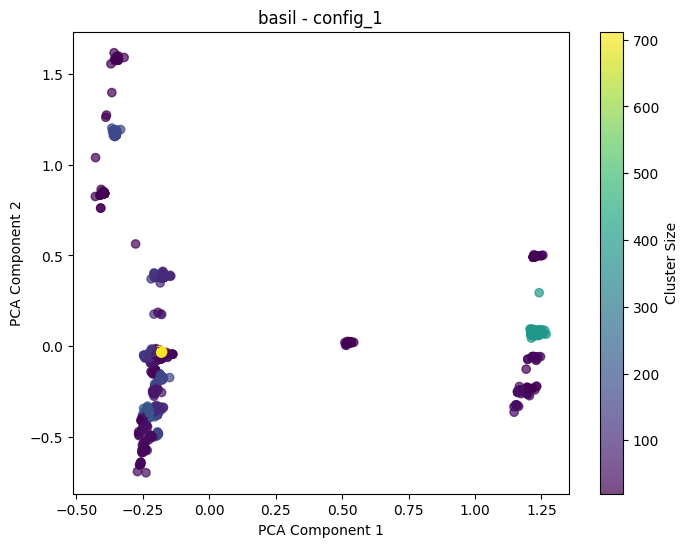

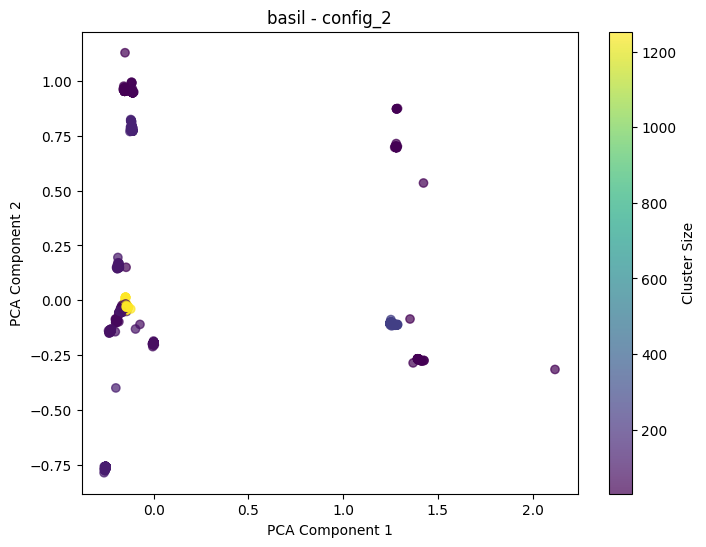

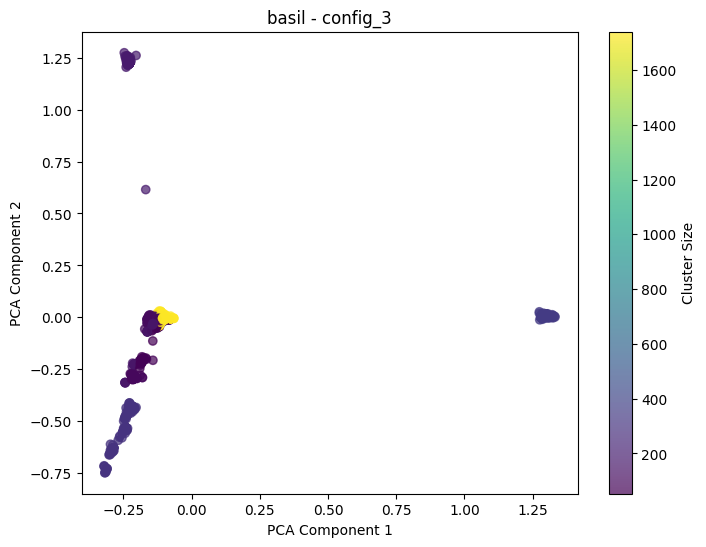

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

for name, configs in results.items():
    for config_name, data in configs.items():
        clustered_df = data["clustered_df"].dropna(subset=['entity_cluster'])
        
        # Recompute feature matrix from entities
        if 'entities' in clustered_df.columns:
            clustered_df['entities_str'] = clustered_df['entities'].apply(lambda x: ' '.join(x))
            vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
            X_sparse = vectorizer.fit_transform(clustered_df['entities_str'])

            # Perform PCA to reduce to 2D for visualization
            pca = PCA(n_components=2, random_state=42)
            X_reduced = pca.fit_transform(X_sparse.toarray())
        else:
            print(f"No 'entities' column found in {name} - {config_name}. Skipping...")
            continue
        
        cluster_sizes = clustered_df['entity_cluster'].value_counts()

        # Map cluster size to color intensity
        cluster_colors = clustered_df['entity_cluster'].map(lambda x: cluster_sizes[x] if x != -1 else 0)

        # Normalize cluster sizes for color mapping
        norm = plt.Normalize(vmin=cluster_colors.min(), vmax=cluster_colors.max())
        cmap = plt.cm.viridis

        # Plot the 2D PCA reduced data with color reflecting cluster size
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_colors, cmap=cmap, alpha=0.7, norm=norm)
        plt.colorbar(scatter, label='Cluster Size')
        plt.title(f"{name} - {config_name}")
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

for name, configs in results.items():
    for config_name, data in configs.items():
        clustered_df = data["clustered_df"].dropna(subset=['entity_cluster'])
        labels = clustered_df['entity_cluster']
        
        # Combine all entities into a single string for each data point
        entities_str = clustered_df['entities'].apply(lambda x: ' '.join(x))
        
        # Convert entities into numerical features using TF-IDF Vectorizer
        vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
        X = vectorizer.fit_transform(entities_str)
    
        score = silhouette_score(X, labels)
        print(f"{name} - {config_name}: Silhouette Score = {score:.3f}")



annomatic - config_1: Silhouette Score = 0.175
annomatic - config_2: Silhouette Score = 0.140
annomatic - config_3: Silhouette Score = 0.156
babe - config_1: Silhouette Score = 0.116
babe - config_2: Silhouette Score = 0.166
babe - config_3: Silhouette Score = 0.123
basil - config_1: Silhouette Score = 0.160
basil - config_2: Silhouette Score = 0.196
basil - config_3: Silhouette Score = 0.144
